In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch_optimizer as optim  # 提供 Ranger 优化器
from torch.optim.lr_scheduler import OneCycleLR, StepLR
from torch.amp import autocast, GradScaler

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from coordatt import CoordAtt

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 超参数
batch_size = 128
lr = 1e-3
num_epochs = 20
model_name = 'resnet50'  # 可选：'simplecnn' 或 'resnet50'

# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
# 数据集根目录
root_dir = 'data/iCubWorld'
train_dir = 'data/iCubWorld/train'


In [4]:
def get_mean_std(train_dir):
    # 1. 定义只做 ToTensor 的 transform（将像素从 [0,255] 归一到 [0,1]）
    to_tensor = transforms.ToTensor()

    # 2. 用 ImageFolder 加载训练集（不做任何裁剪／增强）
    dataset = torchvision.datasets.ImageFolder(train_dir, transform=to_tensor)

    # 3. 构造 DataLoader，顺序读取所有样本
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,      # 不打乱，顺序也没关系
        num_workers=4
    )

    # 4. 累加器：记录所有像素的总和与平方和，以及总像素数
    sum_rgb     = torch.zeros(3)  # 各通道所有像素之和
    sum_sq_rgb  = torch.zeros(3)  # 各通道所有像素平方之和
    total_pixels = 0              # 所有图片的像素总数（batch * H * W）

    # 5. 遍历 DataLoader，累加求和
    for imgs, _ in loader:
        # imgs: Tensor of shape (B, 3, H, W), 值在 [0,1]
        b, c, h, w = imgs.shape

        # 累加像素值
        # 对 (B,3,H,W) 张量按 dim=[0,2,3] 求和，得到 (3,) 向量
        sum_rgb    += imgs.sum(dim=[0, 2, 3])
        sum_sq_rgb += (imgs ** 2).sum(dim=[0, 2, 3])

        # 累加像素总数
        total_pixels += b * h * w

    # 6. 计算均值与标准差
    # mean = E[x]
    mean = sum_rgb / total_pixels
    # std  = sqrt(E[x^2] - (E[x])^2)
    std  = (sum_sq_rgb / total_pixels - mean ** 2).sqrt()

    return mean, std


mean, std = get_mean_std(train_dir)
print('Dataset mean:', mean.tolist())
print('Dataset std :', std.tolist())

Dataset mean: [0.4298136234283447, 0.39438438415527344, 0.36725589632987976]
Dataset std : [0.22690562903881073, 0.20988260209560394, 0.19859203696250916]


In [5]:
# # 1. 定义只做 ToTensor 的 transform（将像素从 [0,255] 归一到 [0,1]）
# to_tensor = transforms.ToTensor()

# # 2. 用 ImageFolder 加载训练集（不做任何裁剪／增强）
# train_dir = 'data/iCubWorld/train'
# dataset = torchvision.datasets.ImageFolder(train_dir, transform=to_tensor)

# # 3. 构造 DataLoader，顺序读取所有样本
# loader = DataLoader(
#     dataset,
#     batch_size=64,
#     shuffle=False,      # 不打乱，顺序也没关系
#     num_workers=4
# )

# # 4. 累加器：记录所有像素的总和与平方和，以及总像素数
# sum_rgb     = torch.zeros(3)  # 各通道所有像素之和
# sum_sq_rgb  = torch.zeros(3)  # 各通道所有像素平方之和
# total_pixels = 0              # 所有图片的像素总数（batch * H * W）

# # 5. 遍历 DataLoader，累加求和
# for imgs, _ in loader:
#     # imgs: Tensor of shape (B, 3, H, W), 值在 [0,1]
#     b, c, h, w = imgs.shape

#     # 累加像素值
#     # 对 (B,3,H,W) 张量按 dim=[0,2,3] 求和，得到 (3,) 向量
#     sum_rgb    += imgs.sum(dim=[0, 2, 3])
#     sum_sq_rgb += (imgs ** 2).sum(dim=[0, 2, 3])

#     # 累加像素总数
#     total_pixels += b * h * w

# # 6. 计算均值与标准差
# # mean = E[x]
# mean = sum_rgb / total_pixels
# # std  = sqrt(E[x^2] - (E[x])^2)
# std  = (sum_sq_rgb / total_pixels - mean ** 2).sqrt()

# print('Dataset mean:', mean.tolist())
# print('Dataset std :', std.tolist())

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None, ca_reduction=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Coordinate Attention
        self.ca = CoordAtt(planes, planes, reduction=ca_reduction)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # 在第二个 BN 后应用 CA
        out = self.ca(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, ca_reduction=32):
        super().__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # ResNet-18 layers: blocks = [2,2,2,2]
        self.layer1 = self._make_layer(64,  64,  blocks=2, stride=1, ca_reduction=ca_reduction)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2, ca_reduction=ca_reduction)
        self.layer3 = self._make_layer(128,256, blocks=2, stride=2, ca_reduction=ca_reduction)
        self.layer4 = self._make_layer(256,512, blocks=2, stride=2, ca_reduction=ca_reduction)
        # Pool + FC
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self._init_weights()

    def _make_layer(self, in_planes, planes, blocks, stride=1, ca_reduction=32):
        downsample = None
        if stride != 1 or in_planes != planes * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes * BasicBlock.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * BasicBlock.expansion),
            )
        layers = []
        # 第一个 block 可能有下采样
        layers.append(BasicBlock(in_planes, planes, stride, downsample, ca_reduction))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes * BasicBlock.expansion, planes, 1, None, ca_reduction))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None, ca_reduction=32):
        super().__init__()
        # 1×1 降维
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        # 3×3 空洞感受野
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        # 1×1 恢复维度
        self.conv3 = nn.Conv2d(planes, planes * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(planes * self.expansion)

        # **CoordAtt 模块**
        self.ca    = CoordAtt(planes * self.expansion,
                              planes * self.expansion,
                              reduction=ca_reduction)
        # 如果跨步或通道数变化，用下采样调整捷径
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))


        # 在 addition 之前做 Coordinate Attention
        out = self.ca(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # 初始层（可以改成 3×3 conv + BN + ReLU，去掉大核7×7）
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 四个 stage，block 数量可按 ResNet-50 ([3,4,6,3]) 或简化
        self.layer1 = self.make_layer( 64,  64, blocks=3, stride=1)  # 输出 256 通道
        self.layer2 = self.make_layer(256, 128, blocks=4, stride=2)  # 输出 512 通道
        self.layer3 = self.make_layer(512, 256, blocks=6, stride=2)  # 输出1024 通道
        self.layer4 = self.make_layer(1024,512, blocks=3, stride=2)  # 输出2048 通道

        # 全局池化 + 全连接
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        self._init_weights()

    def make_layer(self, in_planes, planes, blocks, stride=1):
        downsample = None
        out_planes = planes * Bottleneck.expansion
        if stride != 1 or in_planes != out_planes:
            # 用 1×1 卷积来匹配维度 & 跨步下采样
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes),
            )
        layers = [Bottleneck(in_planes, planes, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(out_planes, planes))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He 初始化
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # 全连接层也可以做类似初始化
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                # BN 的 weight 初始化为 1，bias 为 0
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [7]:
# 可选模型：SimpleCNN 或 ResNet50
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


def get_model(name='resnet50', num_classes=10):
    if name.lower() == 'resnet50':
        model = torchvision.models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        model = ResNet50(num_classes)
    return model







In [8]:
def train_epoch(model, device, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, device, loader, criterion):
    model.eval()
    correct, total_loss = 0, 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)
    

In [9]:
def split_train_val_index(full_train, train_ratio=0.8):
    train_indices, val_indices = random_split(
        list(range(len(full_train))),
        [int(len(full_train) * train_ratio), len(full_train) - int(len(full_train) * train_ratio)]
    )
    return train_indices, val_indices

In [10]:
def get_data_augmentation(train_indices, val_indices):
    # 数据增强与标准化
    transform_train = transforms.Compose([
    # —— PIL Image 处理 ——  
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),#, saturation=0.1, hue=0.05),
    # transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    # transforms.RandomVerticalFlip(),

    # —— 转 Tensor 并归一化到 [0,1] ——  
    transforms.ToTensor(),

    # —— Tensor-only 操作 ——  
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean, std),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),        # 或 Resize((256,256))
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = Subset(
        torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'), transform=transform_train),
        train_indices.indices if hasattr(train_indices, 'indices') else train_indices
    )
    val_set = Subset(
        torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'), transform=transform_train),
        val_indices.indices if hasattr(val_indices, 'indices') else val_indices
    )

    test_bg = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/background'), transform=transform_test)
    test_cat = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/categorization'), transform=transform_test)
    test_demo = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/demonstrator'), transform=transform_test)
    test_robot = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/robot'), transform=transform_test)
    # test_bg = torchvision.datasets.ImageFolder('data/iCubWorld/test/background', transform_test)
    # test_cat = torchvision.datasets.ImageFolder('data/iCubWorld/test/categorization', transform_test)
    # test_demo = torchvision.datasets.ImageFolder('data/iCubWorld/test/demonstrator', transform_test)
    # test_robot = torchvision.datasets.ImageFolder('data/iCubWorld/test/robot', transform_test)
    
    return train_set, val_set, test_bg, test_cat, test_demo, test_robot

In [11]:
# 加载iCubWorld 1.0训练集并拆分为 train/val
full_train = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'),transform=None)
# test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

train_indices, val_indices = split_train_val_index(full_train, train_ratio=0.8)

# get train/val/test sets after data pre-processing and augmentation
train_set, val_set, test_bg, test_cat, test_demo, test_robot = get_data_augmentation(train_indices, val_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

test_bg_loader = DataLoader(test_bg, batch_size=batch_size, shuffle=False, num_workers=4)
test_cat_loader = DataLoader(test_cat, batch_size=batch_size, shuffle=False, num_workers=4)
test_demo_loader = DataLoader(test_demo, batch_size=batch_size, shuffle=False, num_workers=4)
test_robot_loader = DataLoader(test_robot, batch_size=batch_size, shuffle=False, num_workers=4)

test_loaders = {
    'background': test_bg_loader,
    'categorization': test_cat_loader,
    'demonstrator': test_demo_loader,
    'robot': test_robot_loader
}

In [12]:
# full_train.class_to_idx

# for i in range(1):
#     print(f'train_set[{i}]:', train_set[i])
    

## Grid Research

In [13]:


learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [32, 64, 128]
num_epochs_list = [10, 20, 30]


results = []
total_idx  = np.arange(len(full_train))
sub_idx    = np.random.choice(total_idx, size=int(len(full_train)*0.7), replace=False)

sub_dataset = Subset(full_train, sub_idx)

def make_sub_loaders(sub_dataset, batch_size):

    train_idx, val_idx = split_train_val_index(sub_dataset, train_ratio=0.8)
    train_set, val_set, _, _, _, _ = get_data_augmentation(train_idx, val_idx)
    
    return DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2), \
           DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)

for bs, lr, ne in itertools.product(batch_sizes, learning_rates, num_epochs_list):
    print(f"\n=== New combo: batch_size={bs}, lr={lr:.1e}, epochs={ne} ===")
    # 每次都重建模型、优化器
    model     = get_model("SimpleResNetLike").to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Ranger(model.parameters(), lr=lr)
    
    train_loader, val_loader = make_sub_loaders(sub_dataset, bs)
    
    best_val_acc = 0.0
    for epoch in range(ne):
        train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)

        # 打印每个 epoch 的指标
        print(f"[Combo bs={bs} lr={lr:.1e}] "
              f"Epoch {epoch:02d}/{ne} — "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc*100:.2f}%")
        
        # 如果是该组合下的新最佳，更新并打印
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best for this combo: Val Acc = {best_val_acc*100:.2f}%")

    # 一个组合跑完后，输出该组合的最佳结果
    print(f">>> Combo finished: bs={bs}, lr={lr:.1e}, ne={ne} — "
          f"Best Val Acc = {best_val_acc*100:.2f}%")
    
    results.append({
        'batch_size': bs,
        'lr': lr,
        'num_epochs': ne,
        'best_val_acc': best_val_acc
    })

# 保存并打印最优超参
df = pd.DataFrame(results)
df.to_csv('cnn_icub_grid_search_results.csv', index=False)
best = df.loc[df.best_val_acc.idxmax()]
print("Best hyperparams found:", best.to_dict())


=== New combo: batch_size=32, lr=1.0e-03, epochs=10 ===
[Combo bs=32 lr=1.0e-03] Epoch 00/10 — Train Loss: 1.4954, Val Loss: 0.8191, Val Acc: 68.49%
New best for this combo: Val Acc = 68.49%
[Combo bs=32 lr=1.0e-03] Epoch 01/10 — Train Loss: 0.5199, Val Loss: 0.3451, Val Acc: 89.42%
New best for this combo: Val Acc = 89.42%
[Combo bs=32 lr=1.0e-03] Epoch 02/10 — Train Loss: 0.2839, Val Loss: 0.2468, Val Acc: 91.44%
New best for this combo: Val Acc = 91.44%
[Combo bs=32 lr=1.0e-03] Epoch 03/10 — Train Loss: 0.2602, Val Loss: 0.1537, Val Acc: 94.29%
New best for this combo: Val Acc = 94.29%
[Combo bs=32 lr=1.0e-03] Epoch 04/10 — Train Loss: 0.1807, Val Loss: 0.2233, Val Acc: 92.87%
[Combo bs=32 lr=1.0e-03] Epoch 05/10 — Train Loss: 0.1566, Val Loss: 0.1059, Val Acc: 95.96%
New best for this combo: Val Acc = 95.96%
[Combo bs=32 lr=1.0e-03] Epoch 06/10 — Train Loss: 0.1352, Val Loss: 0.1067, Val Acc: 97.15%
New best for this combo: Val Acc = 97.15%
[Combo bs=32 lr=1.0e-03] Epoch 07/10 — T

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_653/1503330603.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


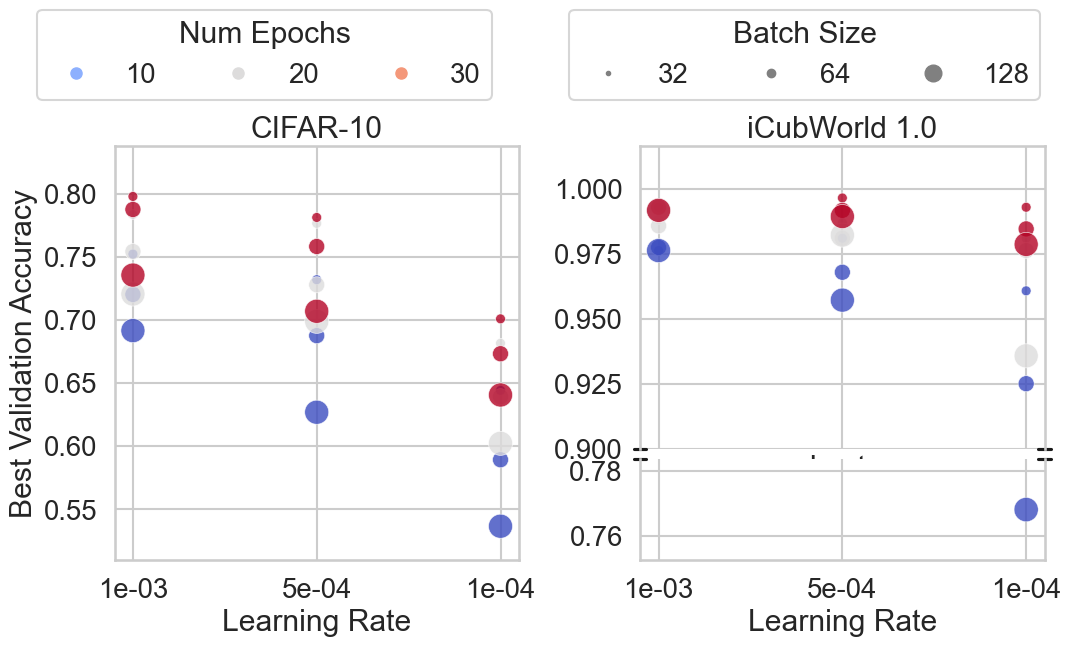

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

# 1. 读取并预处理两个结果 CSV
df1 = pd.read_csv('cnn_cifar_grid_search_results.csv')
df2 = pd.read_csv('cnn_icub_grid_search_results.csv')
for df in (df1, df2):
    df['lr_str'] = df['lr'].apply(lambda x: f"{x:.0e}")

# 2. 全局风格
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)

# 3. 固定 legend 等级
epoch_levels = [10, 20, 30]
batch_levels = [32, 64, 128]
max_batch = max(batch_levels)
max_markersize = 12

# 4. 新建 Figure + GridSpec：左边一个大轴，右边上下各一个小轴
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1],
                       height_ratios=[3, 1],
                       hspace=0.05, wspace=0.3)

# —— 子图1：CIFAR-10（跨两行） —— #
ax1 = fig.add_subplot(gs[:, 0])
sns.scatterplot(
    data=df1, x='lr_str', y='best_val_acc',
    hue='num_epochs', hue_order=epoch_levels,
    size='batch_size', size_order=batch_levels,
    palette='coolwarm', sizes=(50, 300),
    alpha=0.8, edgecolor='w', linewidth=0.5,
    legend='full',
    ax=ax1
)
ax1.set(title='CIFAR-10', xlabel='Learning Rate', ylabel='Best Validation Accuracy')
# 动态设置 y 轴范围
y1min, y1max = df1['best_val_acc'].min(), df1['best_val_acc'].max()
ax1.set_ylim(y1min * 0.95, y1max * 1.05)
# 提取并移除自动 legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend_.remove()

# —— 子图2：iCubWorld 1.0 —— #
# 上半段
ax2_top = fig.add_subplot(gs[0, 1], sharex=ax1)
sns.scatterplot(
    data=df2, x='lr_str', y='best_val_acc',
    hue='num_epochs', hue_order=epoch_levels,
    size='batch_size', size_order=batch_levels,
    palette='coolwarm', sizes=(50, 300),
    alpha=0.8, edgecolor='w', linewidth=0.5,
    legend=False,
    ax=ax2_top
)
ax2_top.set(title='iCubWorld 1.0')
# 下半段
ax2_bottom = fig.add_subplot(gs[1, 1], sharex=ax1)
sns.scatterplot(
    data=df2, x='lr_str', y='best_val_acc',
    hue='num_epochs', hue_order=epoch_levels,
    size='batch_size', size_order=batch_levels,
    palette='coolwarm', sizes=(50, 300),
    alpha=0.8, edgecolor='w', linewidth=0.3,
    legend=False,
    ax=ax2_bottom
)
ax2_bottom.set(xlabel='Learning Rate')

# 根据 df2 数据，把右侧上/下两轴分别定区间
y2min, y2max = df2['best_val_acc'].min(), df2['best_val_acc'].max()
break_pt = 0.90  # 断点，0.90 以上视为上部，其余为下部
ax2_top.set_ylim(break_pt, y2max * 1.02)
ax2_bottom.set_ylim(y2min * 0.98, y2min * 1.02)
ax2_top.yaxis.label.set_visible(False)
ax2_bottom.yaxis.label.set_visible(False)

# 隐藏断轴处的脊线 & 刻度
ax2_top.spines['bottom'].set_visible(False)
ax2_bottom.spines['top'].set_visible(False)
ax2_top.tick_params(labelbottom=False)  # 隐藏上轴的 x 标签
d = .015  # 断裂符号大小
kwargs = dict(transform=ax2_top.transAxes, color='k', clip_on=False)
ax2_top.plot((-d, +d), (0, 0), **kwargs)
ax2_top.plot((1 - d, 1 + d), (0, 0), **kwargs)
kwargs.update(transform=ax2_bottom.transAxes)
ax2_bottom.plot((-d, +d), (1, 1), **kwargs)
ax2_bottom.plot((1 - d, 1 + d), (1, 1), **kwargs)

# —— 手动构造 Figure 级别的 proxy legend —— #
# 颜色 legend：Num Epochs
palette = sns.color_palette('coolwarm', len(epoch_levels))
epoch_handles = [
    Line2D([0], [0],
           marker='o', color=palette[i],
           linestyle='', markersize=8,
           label=str(epoch_levels[i]))
    for i in range(len(epoch_levels))
]

# 大小 legend：Batch Size
batch_handles = []
for b in batch_levels:
    ms = b / max_batch * max_markersize
    batch_handles.append(
        Line2D([0], [0],
               marker='o', color='gray',
               linestyle='', markersize=ms,
               label=str(b))
    )

# 放置两个 legend
fig.subplots_adjust(top=0.80)
fig.legend(
    handles=epoch_handles, labels=[str(e) for e in epoch_levels],
    title='Num Epochs',
    loc='upper center', bbox_to_anchor=(0.25, 1.05),
    ncol=len(epoch_levels), frameon=True
)
fig.legend(
    handles=batch_handles, labels=[str(b) for b in batch_levels],
    title='Batch Size',
    loc='upper center', bbox_to_anchor=(0.7, 1.05),
    ncol=len(batch_levels), frameon=True
)

plt.tight_layout()
plt.show()

## 正式训练

In [14]:


# 模型、损失、优化器
model = get_model("SimpleResNetLike").to(device)

# Use ResNet50 as the model
num_classes = 10
# model = torchvision.models.resnet50(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# model = SimpleCNN(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=num_epochs)

# get the information of the optimizer
print(optimizer)

# 训练与验证
train_losses, val_losses, val_accs = [], [], []

best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
    # print(f"the learning rate is {scheduler.get_last_lr()}")
    val_loss, val_acc = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model/best_model_cnn_icubr.pth')

    
    # —— 更新学习率 —— 
    scheduler.step()
    new_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch:02d}] after sched  | lr = {new_lr:.8e}\n")





Ranger (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 4e-05
    k: 6
    lr: 3.9999999999999996e-05
    max_lr: 0.001
    max_momentum: 0.95
    min_lr: 4e-09
    step_counter: 0
    weight_decay: 0.0001
)


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 00 | Train Loss: 2.3648 | Val Loss: 2.3091 | Val Acc: 11.16%
[Epoch 00] after sched  | lr = 1.31671843e-04

Epoch 01 | Train Loss: 2.2360 | Val Loss: 2.1528 | Val Acc: 23.73%
[Epoch 01] after sched  | lr = 3.71671843e-04

Epoch 02 | Train Loss: 1.8829 | Val Loss: 1.5907 | Val Acc: 51.29%
[Epoch 02] after sched  | lr = 6.68328157e-04

Epoch 03 | Train Loss: 1.0947 | Val Loss: 0.7242 | Val Acc: 74.52%
[Epoch 03] after sched  | lr = 9.08328157e-04

Epoch 04 | Train Loss: 0.6021 | Val Loss: 0.7882 | Val Acc: 73.19%
[Epoch 04] after sched  | lr = 1.00000000e-03

Epoch 05 | Train Loss: 0.4150 | Val Loss: 0.3048 | Val Acc: 90.01%
[Epoch 05] after sched  | lr = 9.87464006e-04

Epoch 06 | Train Loss: 0.3291 | Val Loss: 0.8168 | Val Acc: 74.02%
[Epoch 06] after sched  | lr = 9.50484632e-04

Epoch 07 | Train Loss: 0.2126 | Val Loss: 1.7906 | Val Acc: 63.95%
[Epoch 07] after sched  | lr = 8.90916178e-04

Epoch 08 | Train Loss: 0.1982 | Val Loss: 0.1521 | Val Acc: 95.75%
[Epoch 08] after sche

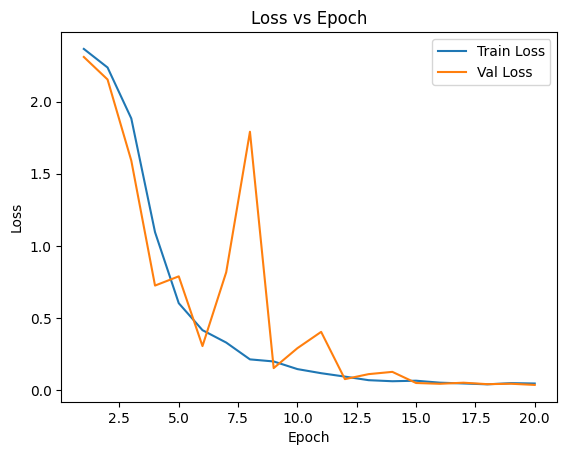

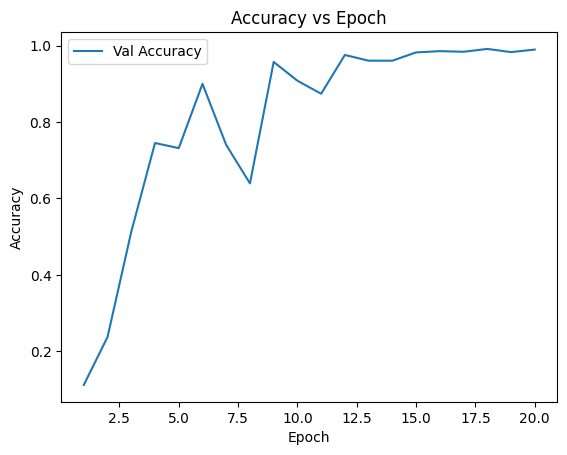

In [15]:
# Loss 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss vs Epoch')
plt.show()

# Accuracy 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy vs Epoch')
plt.show()

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_43831/3254281880.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/be


=== Classification Report on background Set ===
              precision    recall  f1-score   support

     bananas     1.0000    0.5000    0.6667        20
     bottles     1.0000    0.5000    0.6667        20
       boxes     0.2439    1.0000    0.3922        20
       bread     1.0000    0.5000    0.6667        20
        cans     1.0000    0.5000    0.6667        20
      lemons     1.0000    0.5000    0.6667        20
       pears     1.0000    0.5000    0.6667        20
     peppers     1.0000    0.5000    0.6667        20
    potatoes     1.0000    0.5000    0.6667        20
      yogurt     0.3421    0.6500    0.4483        20

    accuracy                         0.5650       200
   macro avg     0.8586    0.5650    0.6174       200
weighted avg     0.8586    0.5650    0.6174       200



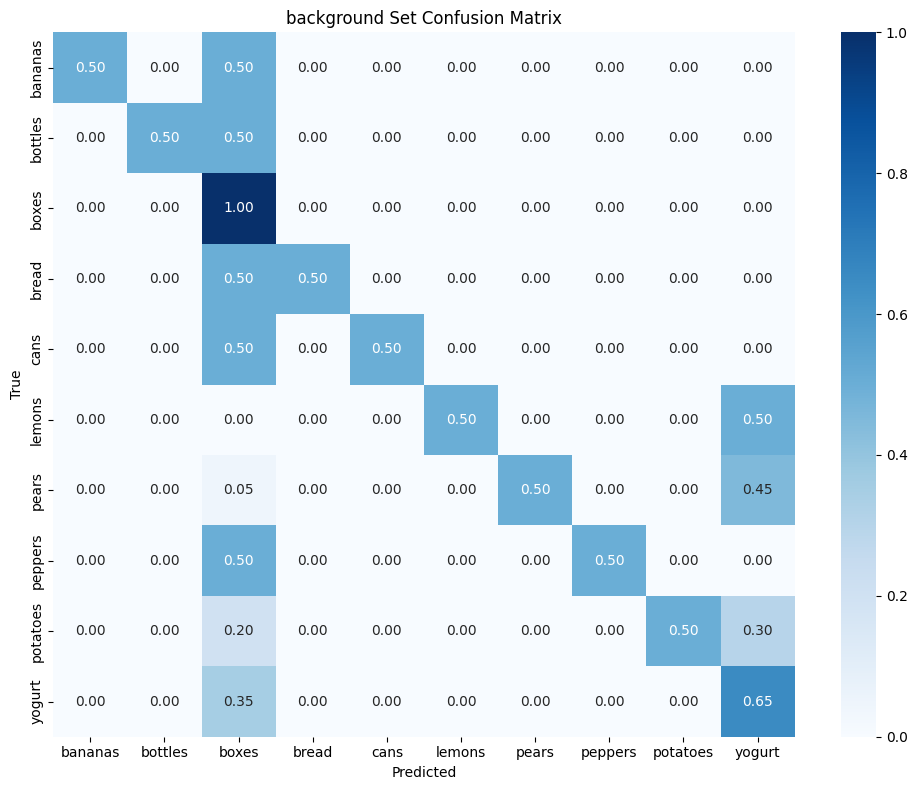


=== Classification Report on categorization Set ===
              precision    recall  f1-score   support

     bananas     1.0000    0.9950    0.9975       200
     bottles     0.5909    0.5200    0.5532       200
       boxes     0.0000    0.0000    0.0000       200
       bread     0.9252    0.9900    0.9565       200
        cans     0.9950    0.9900    0.9925       200
      lemons     0.9132    1.0000    0.9547       200
       pears     0.8786    0.9050    0.8916       200
     peppers     0.6582    0.9050    0.7621       200
    potatoes     0.8895    0.8050    0.8451       200
      yogurt     0.1223    0.1393    0.1302       201

    accuracy                         0.7246      2001
   macro avg     0.6973    0.7249    0.7083      2001
weighted avg     0.6970    0.7246    0.7081      2001



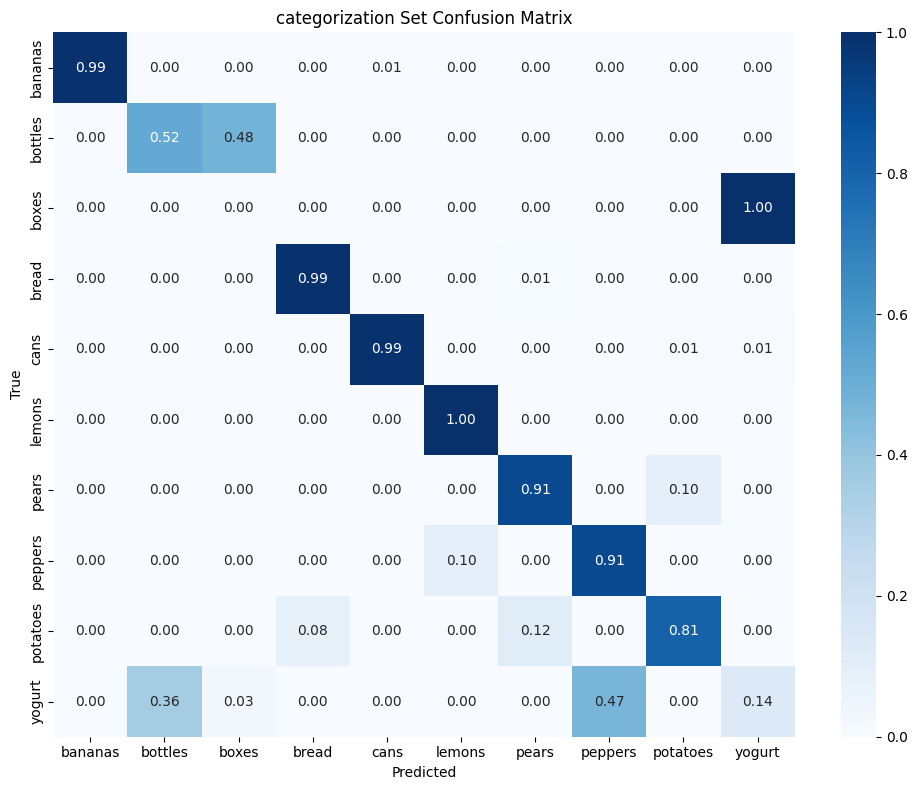


=== Classification Report on demonstrator Set ===
              precision    recall  f1-score   support

     bananas     1.0000    1.0000    1.0000       200
     bottles     0.9091    1.0000    0.9524       200
       boxes     0.9458    0.9600    0.9529       200
       bread     0.8889    1.0000    0.9412       200
        cans     0.8630    0.6300    0.7283       200
      lemons     1.0000    0.9850    0.9924       200
       pears     0.9765    0.4129    0.5804       201
     peppers     0.9756    1.0000    0.9877       200
    potatoes     0.6734    1.0000    0.8048       200
      yogurt     0.7937    0.8850    0.8369       200

    accuracy                         0.8871      2001
   macro avg     0.9026    0.8873    0.8777      2001
weighted avg     0.9026    0.8871    0.8775      2001



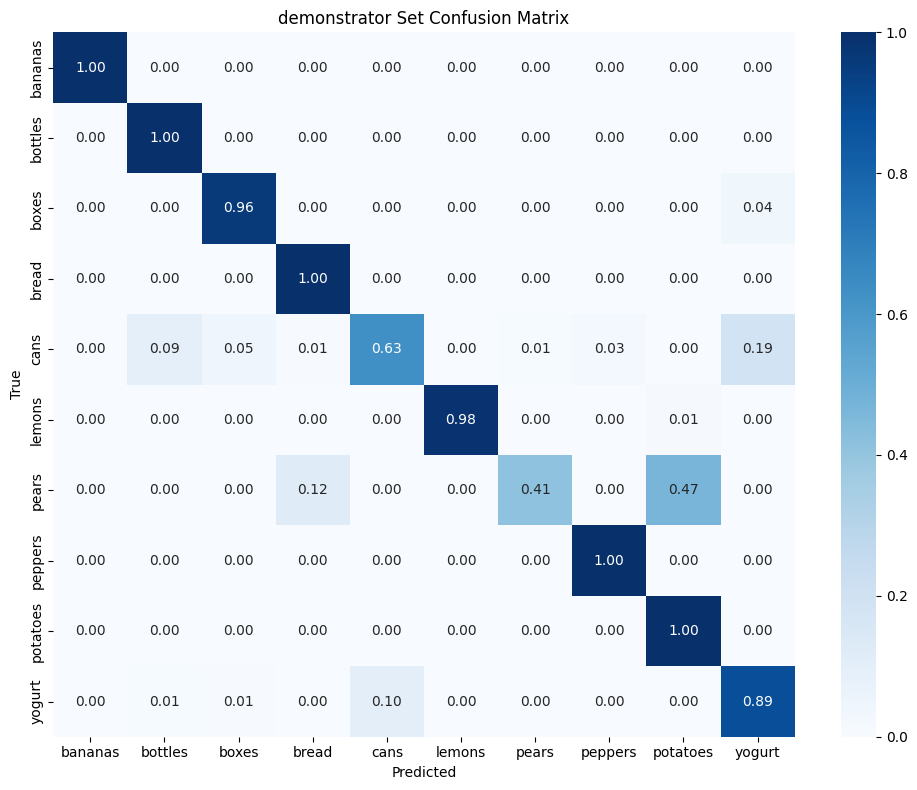


=== Classification Report on robot Set ===
              precision    recall  f1-score   support

     bananas     0.0000    0.0000    0.0000        64
     bottles     0.0000    0.0000    0.0000        76
       boxes     0.0000    0.0000    0.0000        76
       bread     0.0000    0.0000    0.0000        83
        cans     0.0000    0.0000    0.0000        75
      lemons     0.0000    0.0000    0.0000        83
       pears     0.0000    0.0000    0.0000        76
     peppers     0.0860    1.0000    0.1584        69
    potatoes     0.0000    0.0000    0.0000        70
      yogurt     0.0000    0.0000    0.0000       130

    accuracy                         0.0860       802
   macro avg     0.0086    0.1000    0.0158       802
weighted avg     0.0074    0.0860    0.0136       802



/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

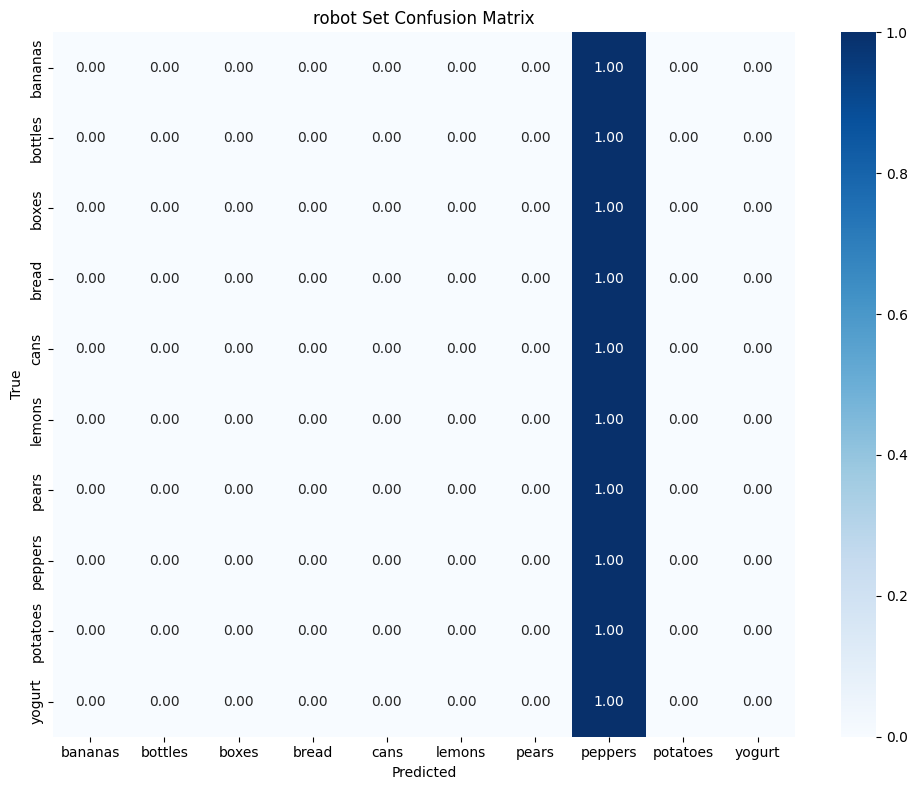

In [18]:
def get_preds_and_targets(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    # 1. 计算 raw CM 并归一化
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # 2. 画图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 假设 test_loaders 是一个 dict，比如 {'testA': loaderA, 'testB': loaderB}
model.load_state_dict(torch.load('./model/best_model_cnn_icubr.pth'))
for name, loader in test_loaders.items():
    # 取出所有真实 & 预测标签
    y_true, y_pred = get_preds_and_targets(model, device, loader)
    # 拿到 class 名称列表
    # 如果 loader.dataset 是 Subset，就取 subset.dataset.classes
    ds = loader.dataset
    if hasattr(ds, 'dataset'):  # Subset
        classes = ds.dataset.classes
    else:
        classes = ds.classes

    report = classification_report(
                y_true,
                y_pred,
                target_names=classes,
                digits=4   # 控制小数点后几位
            )
    print(f"\n=== Classification Report on {name} Set ===")
    print(report)
    
    # 画图
    plot_confusion_matrix(
        y_true, y_pred, classes,
        normalize=True,
        title=f"{name} Set Confusion Matrix"
    )

In [ ]:
# 测试集评估
# test_bg = torchvision.datasets.ImageFolder('data/iCubWorld/test/background', transform_test)
# test_cat = torchvision.datasets.ImageFolder('data/iCubWorld/test/categorization', transform_test)
# test_obj = torchvision.datasets.ImageFolder('data/iCubWorld/test/demonstrator', transform_test)
# test_robot = torchvision.datasets.ImageFolder('data/iCubWorld/test/robot', transform_test)

model.load_state_dict(torch.load('./model/best_model_cnn_icubr.pth'))
# test_loss, test_acc = evaluate(model, device, test_loader, criterion)
# print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc * 100:.2f}%")
for name, loader in test_loaders.items():
    test_loss, test_acc = evaluate(model, device, loader, criterion)
    print(f"\nFinal Test Loss on {name}: {test_loss:.4f} | Final Test Acc on {name}: {test_acc * 100:.2f}%")

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_38093/2069221498.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/bes


Final Test Loss on background: 2.2262 | Final Test Acc on background: 56.50%

Final Test Loss on categorization: 1.2112 | Final Test Acc on categorization: 68.77%

Final Test Loss on demonstrator: 0.5834 | Final Test Acc on demonstrator: 82.31%

Final Test Loss on robot: 10.7743 | Final Test Acc on robot: 9.48%
